# Tutorial 3 : Attentive Neural Processes - 1D GP Data

Last Update : 12 June 2019

**Aim**: 
- Training a simple [Attentive Neural Process] (ANP)
- See how well a ANP "learns" a GP kernel

**Nota Bene:**
- Much more details about the framework and dataset can be found in [Tutorial 1 - Conditional Neural Process].
- Not much hyperparameter optimization done
- Architecture differs slightly from the paper to be more general and modularizable for future work.

[Attentive Neural Process]: https://arxiv.org/abs/1901.05761
[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

**Environment Hypermarameters:**

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False # can also be set in the trainer

## Environment

In [2]:
cd ..

/master


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


## Dataset

In this notebook I only look at the periodic and mattern kernel. See [Tutorial 1 - Conditional Neural Process] for more details.

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [4]:
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, DotProduct, ConstantKernel
from ntbks_viz import plot_posterior_samples, plot_prior_samples, plot_dataset_samples

from ntbks_datasets import GPDataset

In [5]:
X_DIM = 1  # 1D spatial input
Y_DIM = 1  # 1D regression
N_POINTS = 128
N_SAMPLES = 100000 # this is a lot and can work with less

In [6]:
datasets = dict()
kwargs = dict(n_samples=N_SAMPLES, n_points=N_POINTS)
datasets["rbf"] = GPDataset(kernel=1.0 * RBF(length_scale=1.0,
                                             length_scale_bounds=(1e-1, 10.0)),
                            **kwargs)

datasets["periodic"] = GPDataset(kernel=1.0 * ExpSineSquared(length_scale=1.0,
                                                             periodicity=3.0,
                                                             length_scale_bounds=(0.1, 10.0),
                                                             periodicity_bounds=(1.0, 10.0)),
                                 **kwargs)
datasets["non-stationary"] = GPDataset(kernel=(ConstantKernel(0.1, (0.01, 10.0)) *
                                               (DotProduct(sigma_0=1.0,
                                                           sigma_0_bounds=(0.1, 10.0)) ** 2)),
                                       **kwargs)
datasets["matern"] = GPDataset(kernel=1.0 * Matern(length_scale=1.0,
                                                   length_scale_bounds=(1e-1, 10.0),
                                                   nu=1.5),
                               **kwargs)

Let's visualize some of the uncoditional samples from the dataset:

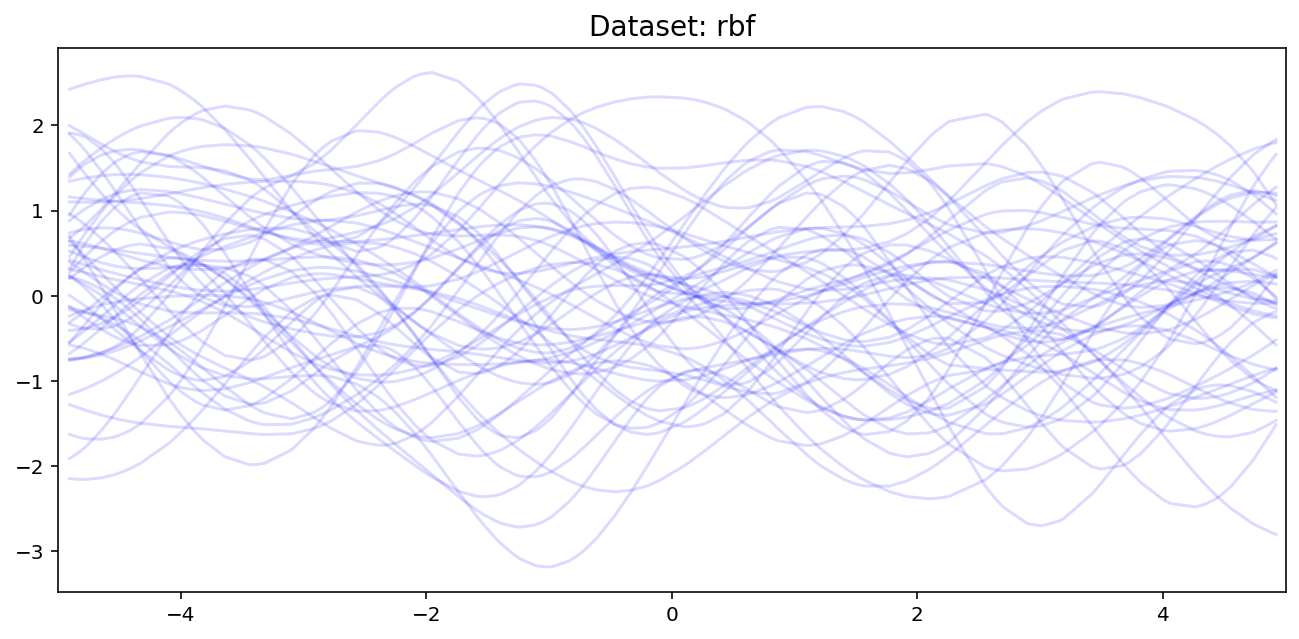

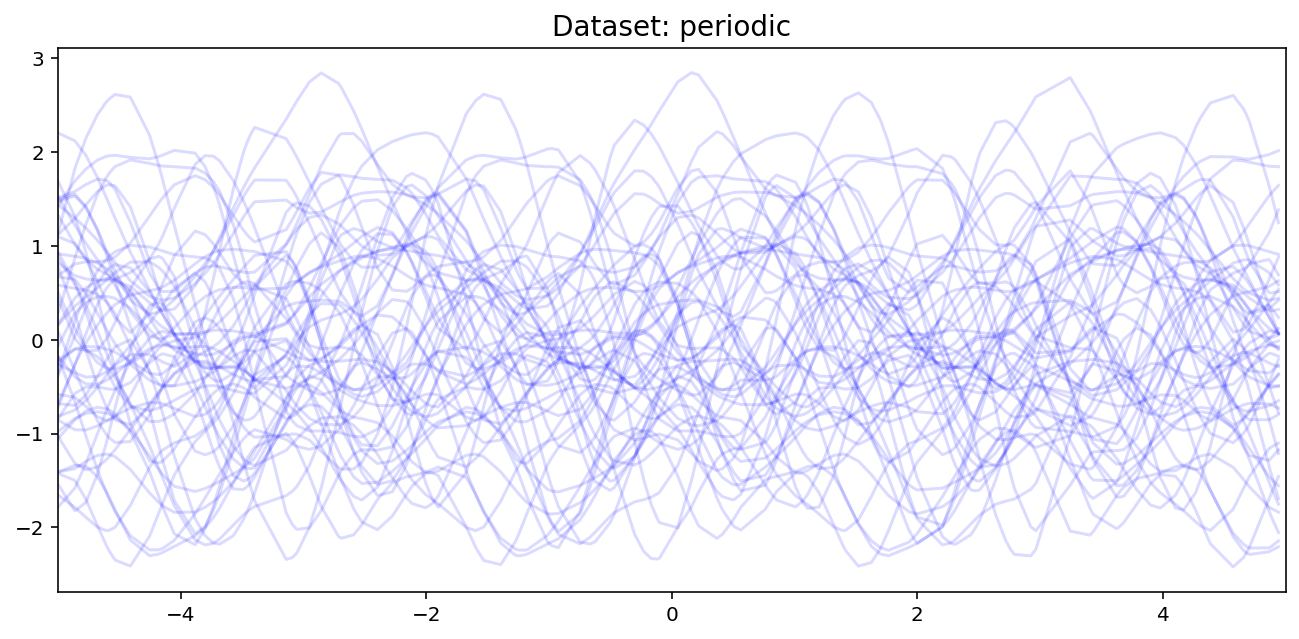

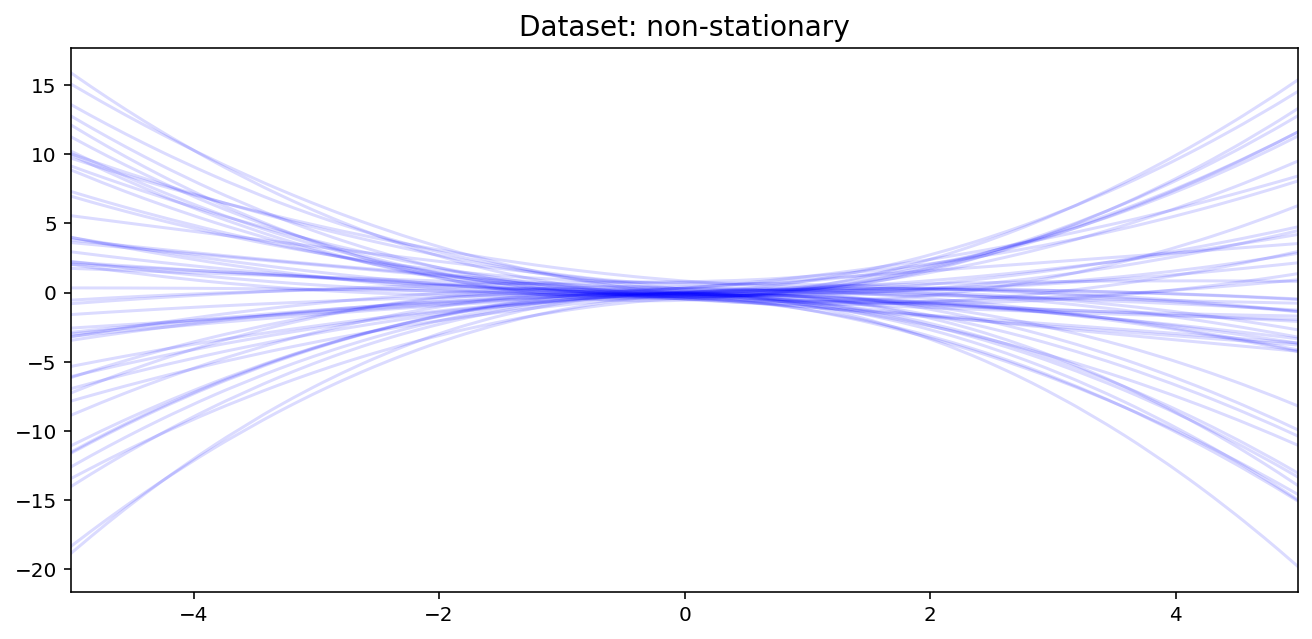

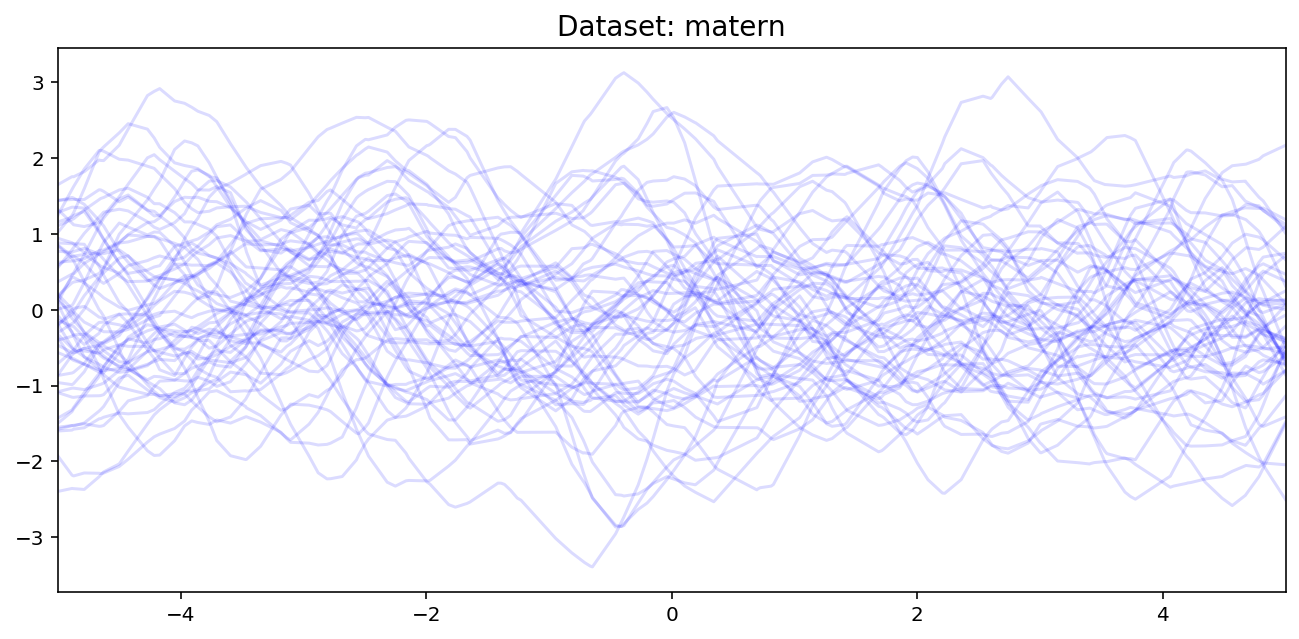

In [7]:
for k, dataset in datasets.items():
    plot_dataset_samples(dataset, title="Dataset: {}".format(k))

## Model

The general model architecture is slightly different from the paper to make it modular and easy to extend, but it is easy to make them equivalent with the right parameters. Refer to [Tutorial 1 - Conditional Neural Process] for an overview main parameters or the docstrings of `NeuralProcess` for all parameters. 

Differences with [Tutorial 1 - Conditional Neural Process]:
- `AttentiveNeuralProcess` and `attention="scaledot"` to use a cross attention instead of aggregation for the deterministic path. Note that the dot product attention is parameter free.
- `encoded_path="both"` to use both a deterministic and a latent path

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [8]:
from torch.distributions import Normal

from skssl.transformers import (NeuralProcessLoss, NeuralProcess, AttentiveNeuralProcess, 
                                SelfAttentionBlock, SinusoidalEncodings)
from skssl.predefined import MLP, merge_flat_input, get_uninitialized_mlp
from skssl.transformers.neuralproc.datasplit import context_target_split

In [9]:
R_DIM = 128
RANGE_CNTXT = (4, 50)  # context points will be sampled uniformly in this range
RANGE_EXTRA_TRGTS = (3, N_POINTS-RANGE_CNTXT[1])  # extra number of targtes points 

In [17]:
def get_cntxt_trgt(*args):
    return context_target_split(*args, range_cntxts=RANGE_CNTXT, range_trgts=RANGE_EXTRA_TRGTS, 
                                is_add_cntxts_to_trgts=True)

def init_model():
    return AttentiveNeuralProcess(X_DIM, Y_DIM,
                         XEncoder=MLP, # encoding X (not done in the paper) improves the results
                         XYEncoder=merge_flat_input(get_uninitialized_mlp(n_hidden_layers=2),
                                                    is_sum_merge=True),  # no self attention encoder 
                         Decoder=merge_flat_input(get_uninitialized_mlp(n_hidden_layers=4),
                                                  is_sum_merge=True),  # no self attention encoder 
                         r_dim=R_DIM,
                         get_cntxt_trgt=get_cntxt_trgt,
                         aggregator=torch.mean,
                         PredictiveDistribution=Normal, 
                         LatentEncoder=MLP,
                          attention="scaledot", # parameter free attention because simple task
                          encoded_path="both") # use both latent  and deterministic path as in paper

In [18]:
# initialize one model for each dataset
data_models = {name: (init_model(), data) 
               for name, data in datasets.items()}

/master/skssl/predefined/mlp.py:56: UserWarning: hidden_size=32 smaller than output=128 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/master/skssl/predefined/mlp.py:56: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


### N Param

Number of parameters (note that I did not play around with this much, this depends a lot on the representation size):

In [19]:
from utils.helpers import count_parameters

In [20]:
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break

N Param: 180930


The increase of parameters doesn't come from attention (as the attention is parameter free in this case), but from the fact that we have a deterministic and a latent path. Using only a deterministic path, the model can be very small. See the following notebook to see such a model with only 35682 parameters : [Small Multihead Conditional Attentive Neural Process]

[Small Multihead Conditional Attentive Neural Process]: Small%20Multihead%20Conditional%20Attentive%20Neural%20Process.ipynb

## Training

In [21]:
from skorch.callbacks import ProgressBar, Checkpoint

from skssl.training import NeuralNetTransformer
from skssl.training.helpers import make_Xy_input

Nota Bene: using a small batch size is probably important as we use fix amount of context in batch, and with attention you don't have aggregation => the number of context points changes the attention mechanism (the softmax) => use small to have many different number of context points but we want a fair comparison so keep `learning rate=1e-3` and `batch_size=64` like other notebook.

In [22]:
N_EPOCHS = 50 # 30 is enough
BATCH_SIZE = 64 
is_RETRAIN = True # if false load precomputed

In [23]:
for k,(neural_proc, dataset) in data_models.items():
    print()
    print("--- {} {} ---".format("Training" if is_RETRAIN else "Loading", k))
    print()
    
    chckpt = Checkpoint(dirname="results/notebooks/neural_process/anp_dotattn_{}".format(k), 
                        monitor='train_loss_best') # train would be same as validation as always resamples
    
    model = NeuralNetTransformer(neural_proc, NeuralProcessLoss,
                                 max_epochs=N_EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 train_split=None,  # don't use cross validation dev set
                                 lr=1e-3, # they use 5e-5 because 16 batch size but that would be slow
                                 callbacks=[ProgressBar(), 
                                            chckpt], # checkpoint best model
                                ) 
    
    if is_RETRAIN:
        _=model.fit(*make_Xy_input(dataset))
    
    # load in all case => even when training loads the best checkpoint
    model.initialize()
    model.load_params(checkpoint=chckpt)


--- Training rbf ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1       48.9397     +  32.6254


      2       11.5324     +  32.5077


      3      -11.5900     +  32.5603


      4      -22.5490     +  20.6963


      5      -29.0347     +  28.2389


      6      -33.9401     +  32.6410


      7      -36.4296     +  32.5716


      8      -40.7241     +  32.4559


      9      -40.9220     +  32.4602


Re-initializing optimizer because the following parameters were re-set: .

--- Training periodic ---



Re-initializing optimizer because the following parameters were re-set: .


RuntimeError: Error(s) in loading state_dict for AttentiveNeuralProcess:
	Unexpected key(s) in state_dict: "attender.key_transform.weight", "attender.query_transform.weight", "attender.value_transform.weight", "attender.post_processor.weight", "attender.post_processor.bias". 

# Trained Prior

In [24]:
EXTRAP_DISTANCE = 2  # add 2 to the right for extrapolation
INTERPOLATION_RANGE = dataset.min_max
EXTRAPOLATION_RANGE = (dataset.min_max[0], dataset.min_max[1]+EXTRAP_DISTANCE )

std: 0.8191947054862975
std: 0.5661317694187163
std: 1.4040623319149015
std: 2.5913229870796206


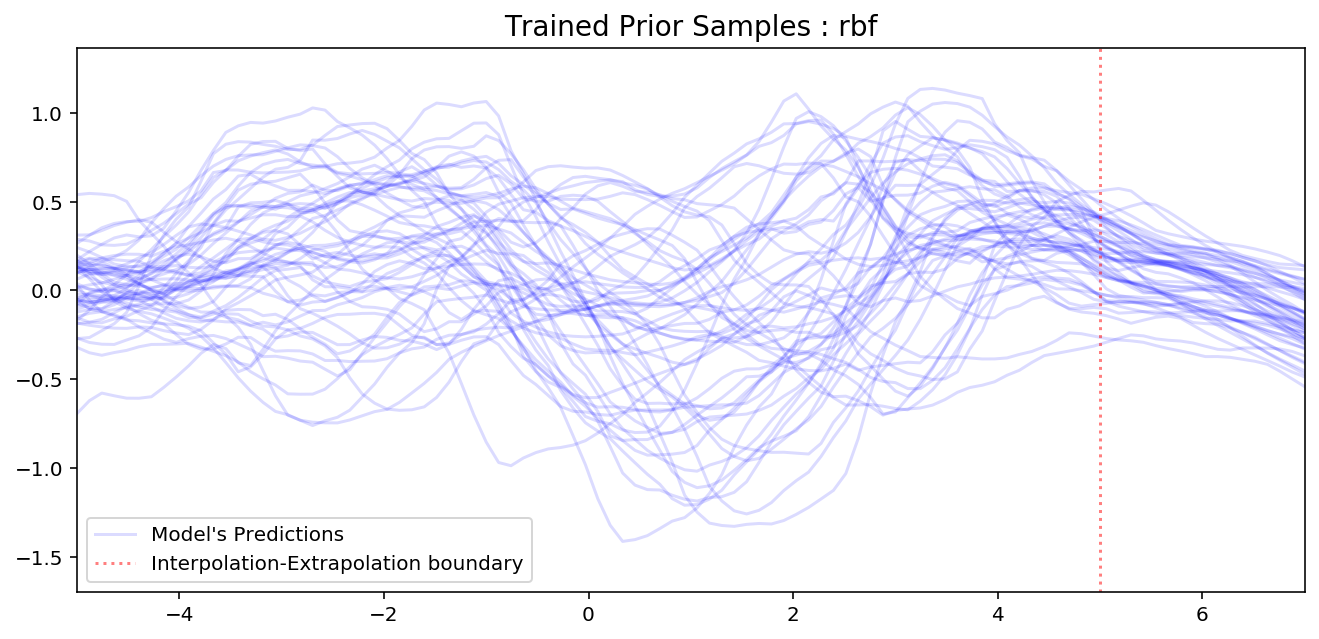

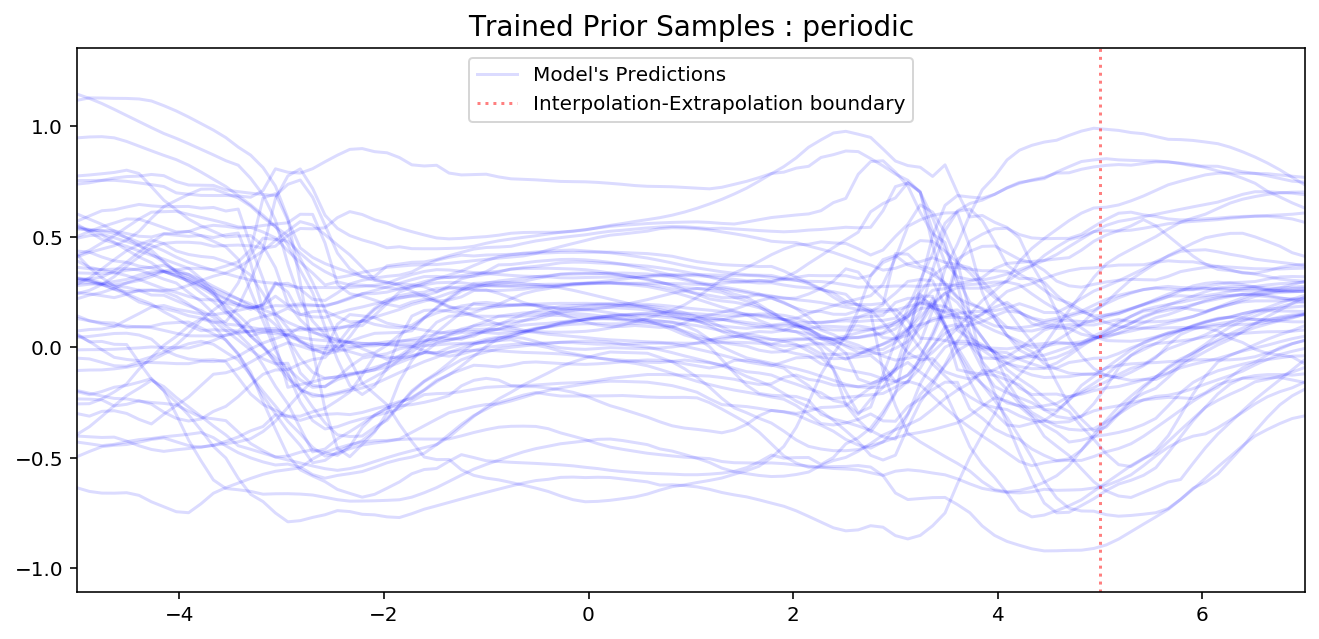

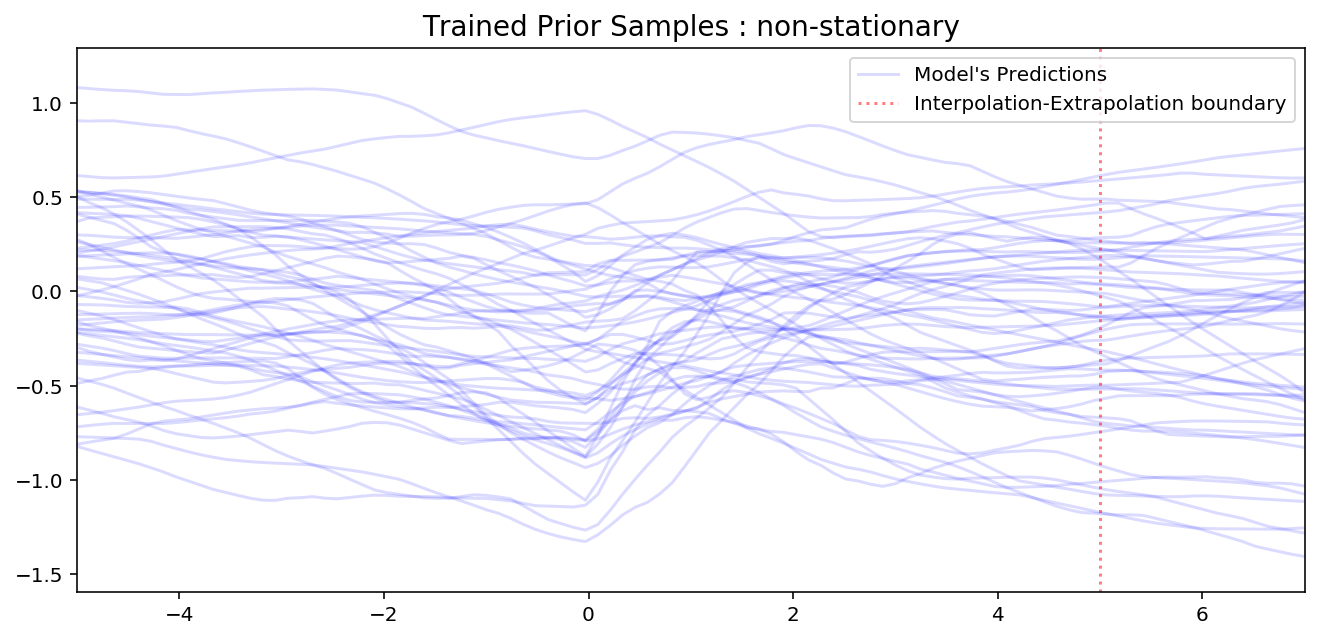

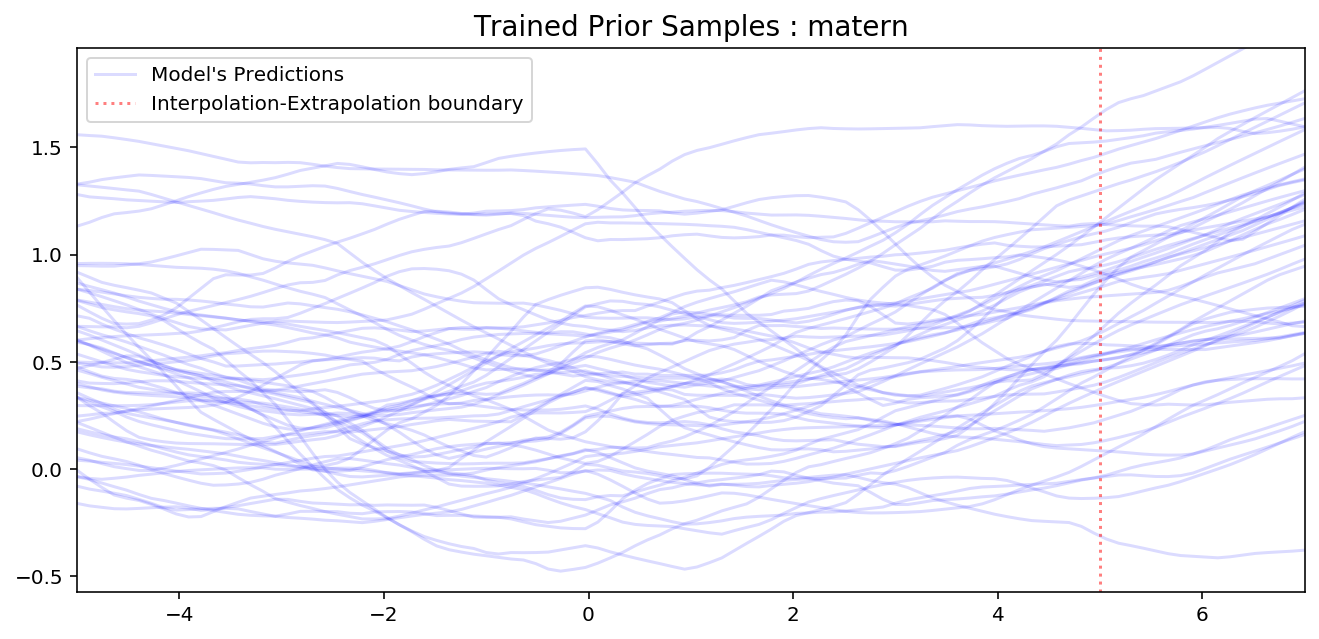

In [25]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, 
                       title="Trained Prior Samples : {}".format(k), 
                       test_min_max=EXTRAPOLATION_RANGE, 
                       train_min_max=INTERPOLATION_RANGE)

# Posterior

std: 0.3707984662055969
std: 0.5527260327339172
std: 48.14186943054199
std: 5.2769922733306895


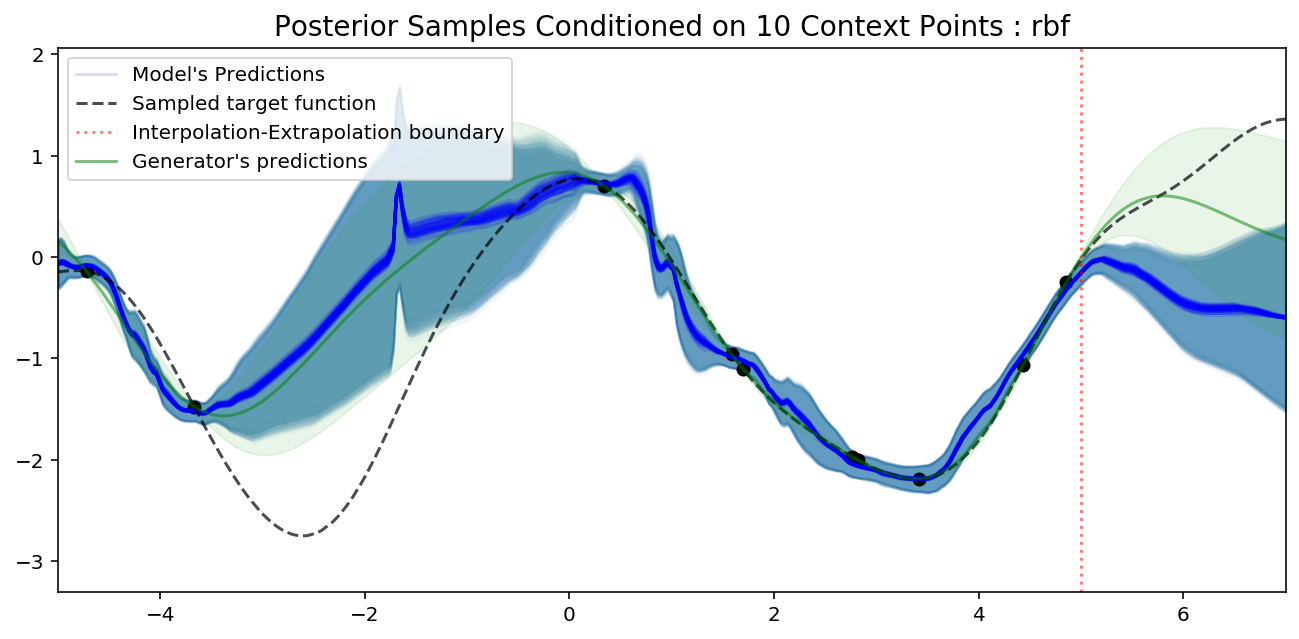

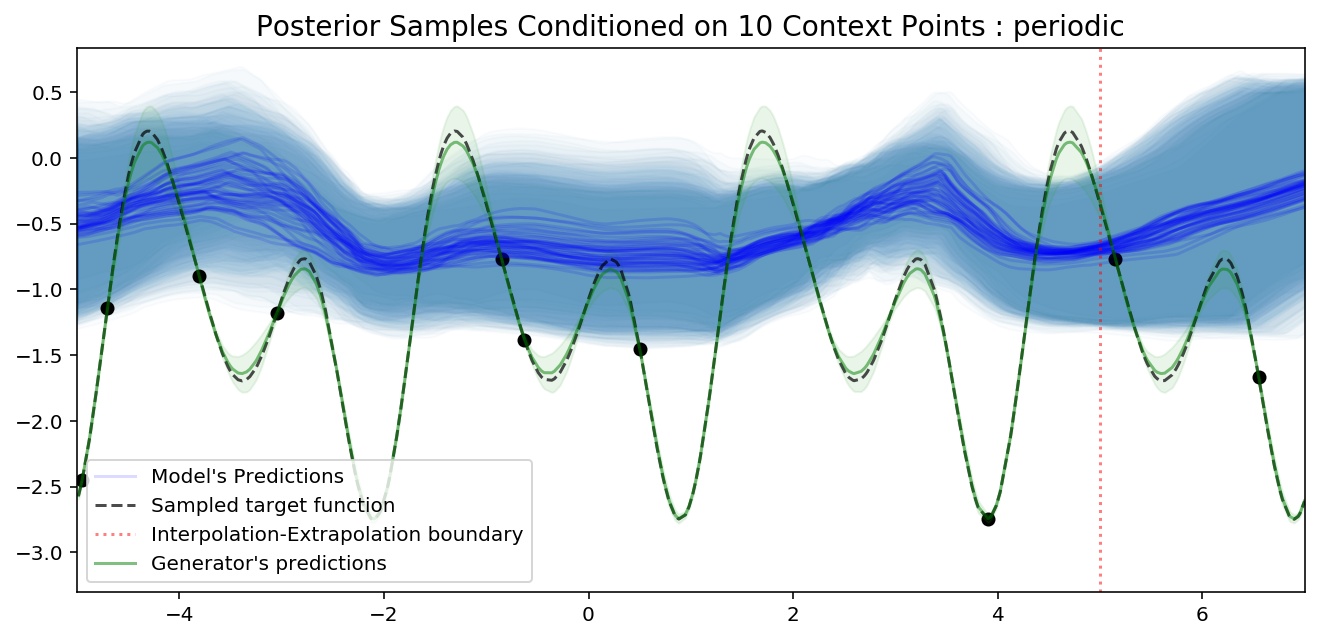

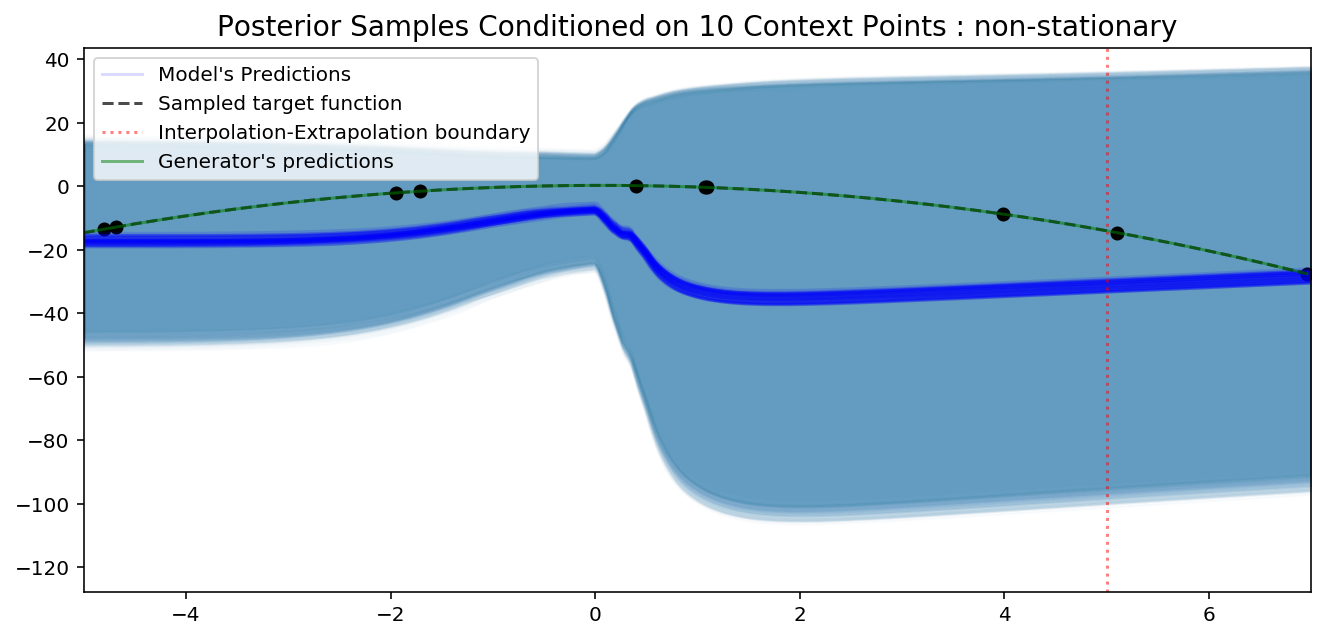

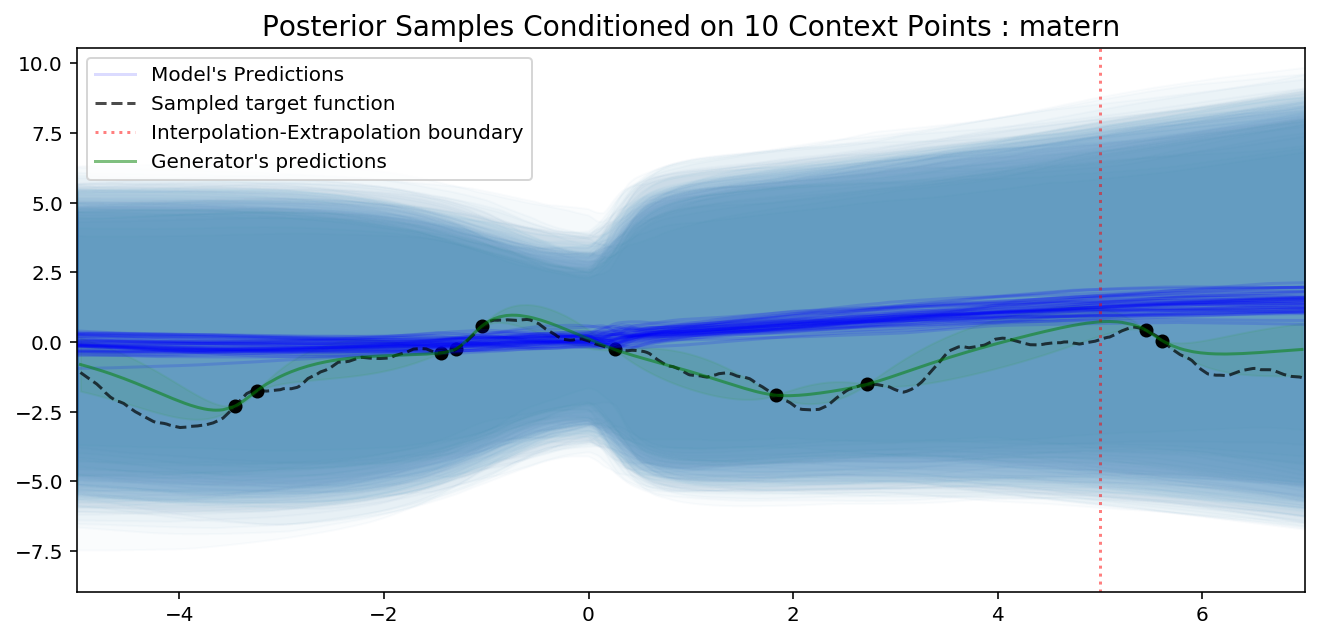

In [26]:
N_CNTXT = 10
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=400,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

std: 0.8532889544963838
std: 0.5457142313321429
std: 1.1971839388211567
std: 0.7808579126993815


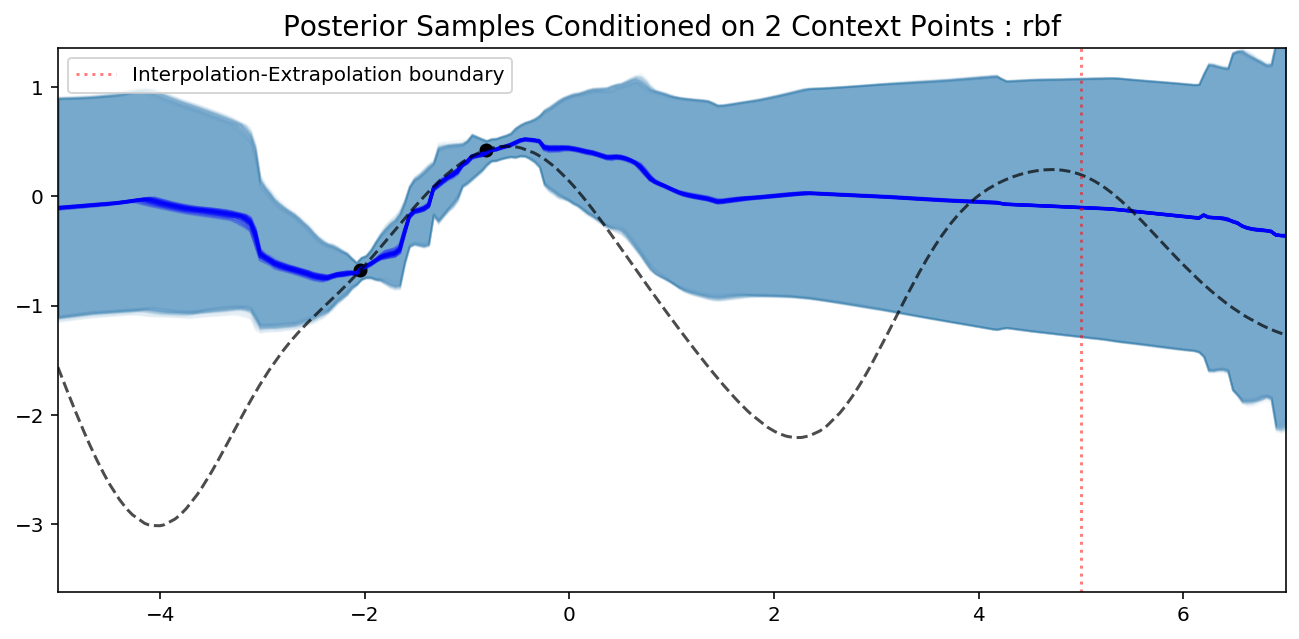

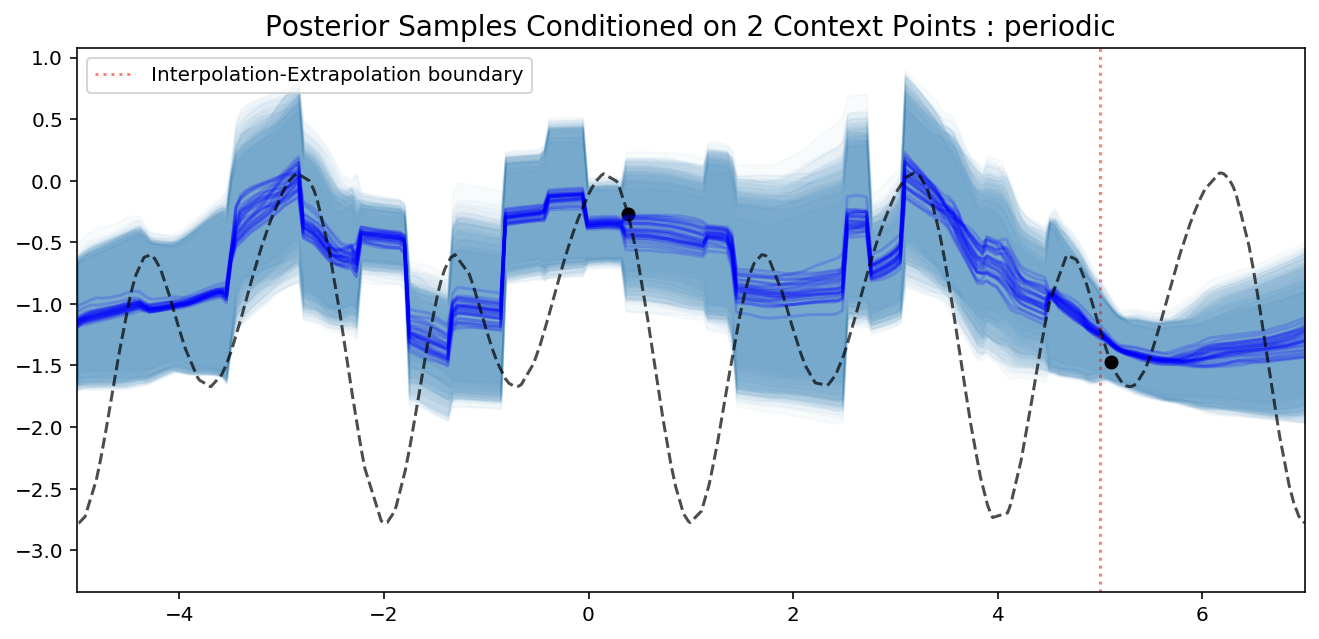

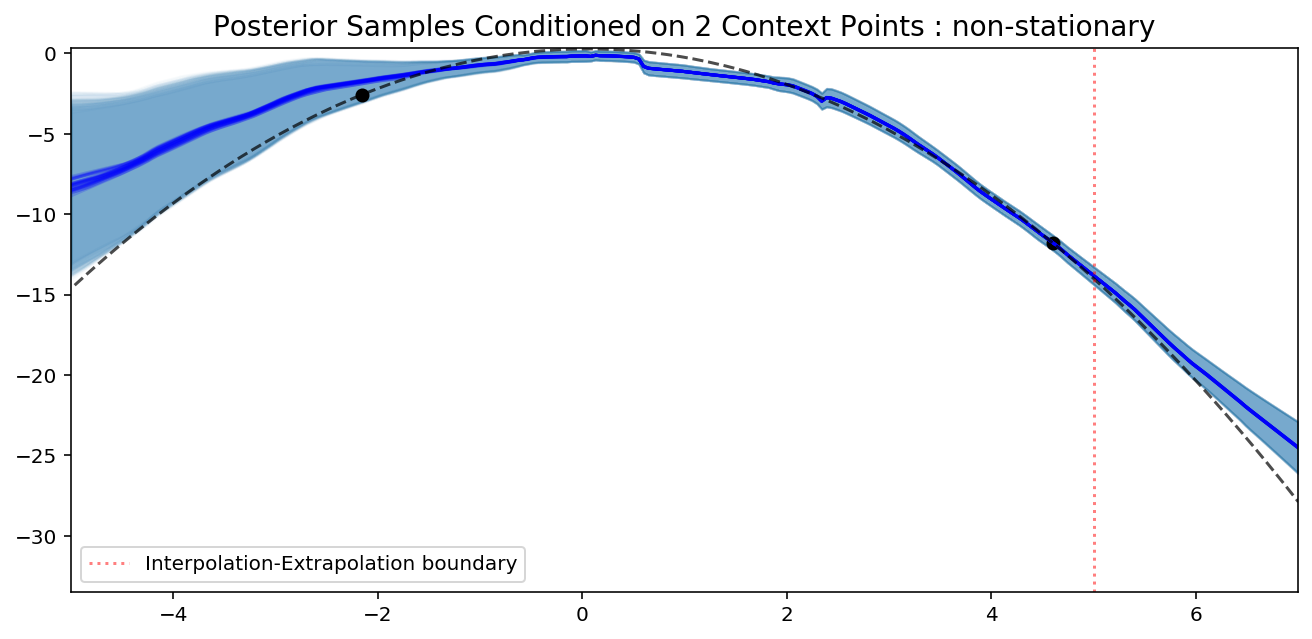

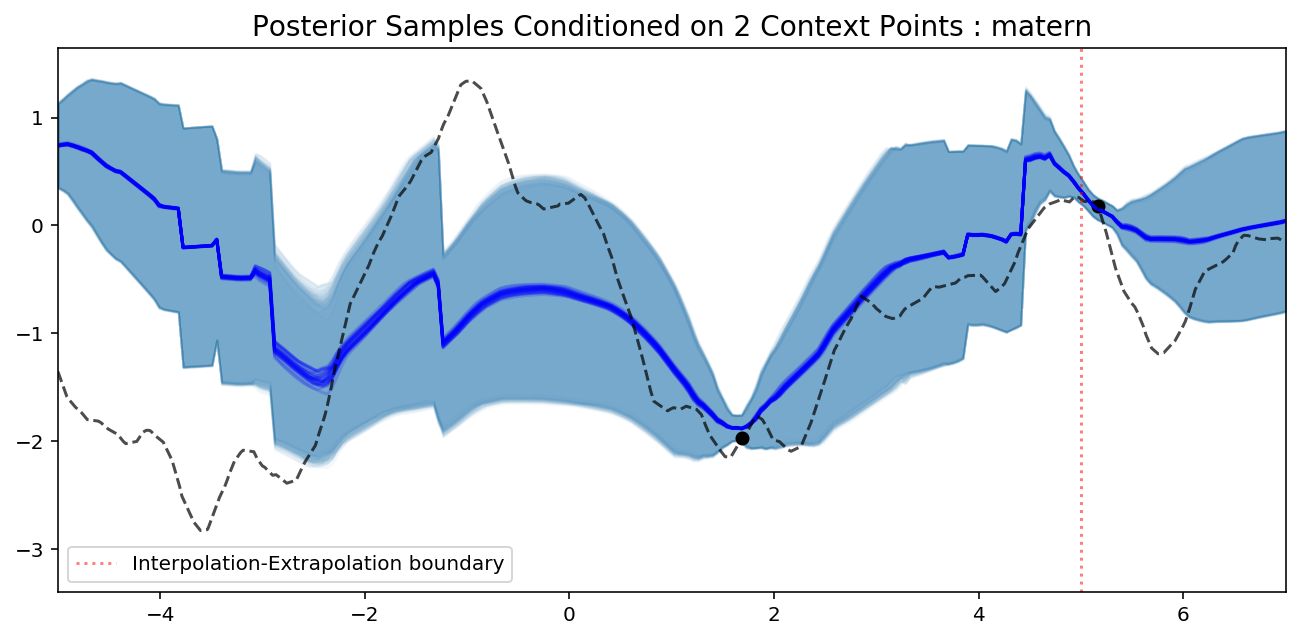

In [24]:
N_CNTXT = 2
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           n_samples=30,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

std: 0.5307370686531067
std: 0.40922578036785134
std: 0.3718962347507477
std: 0.30367391467094423


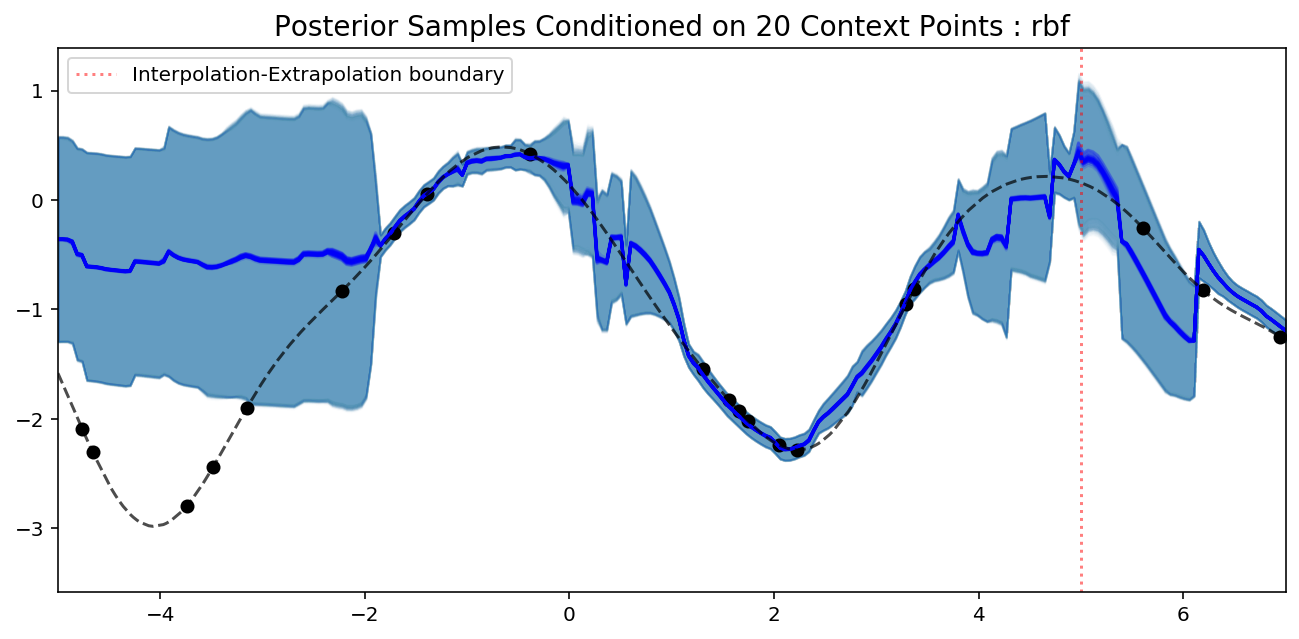

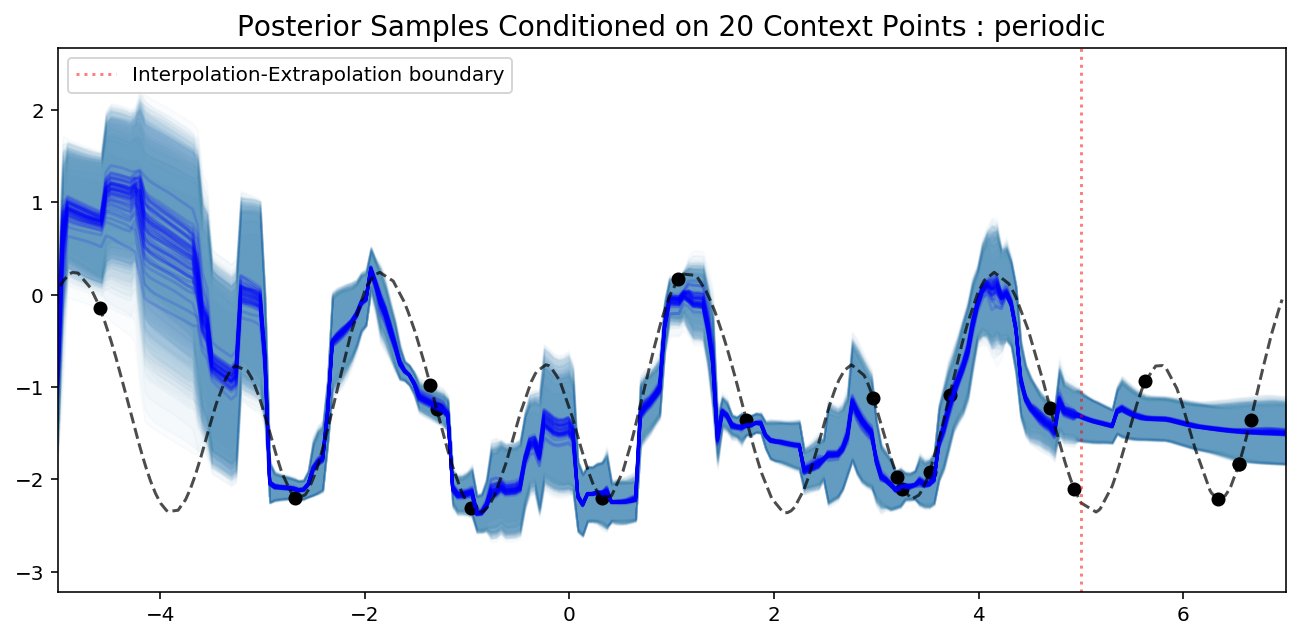

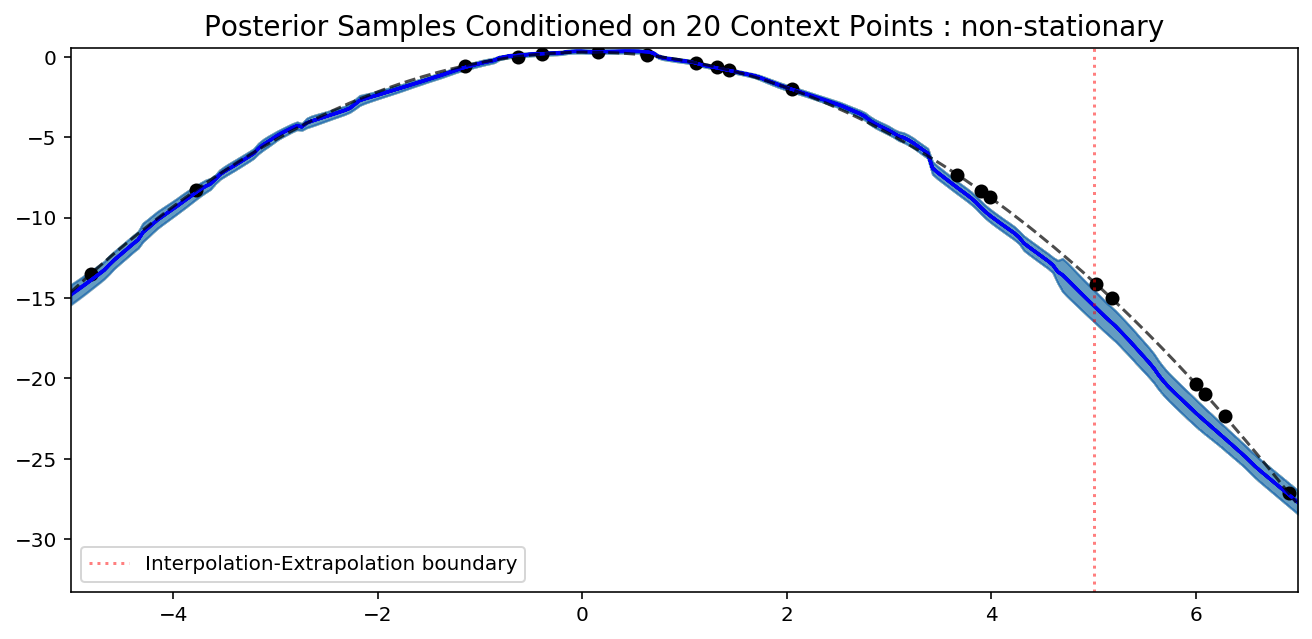

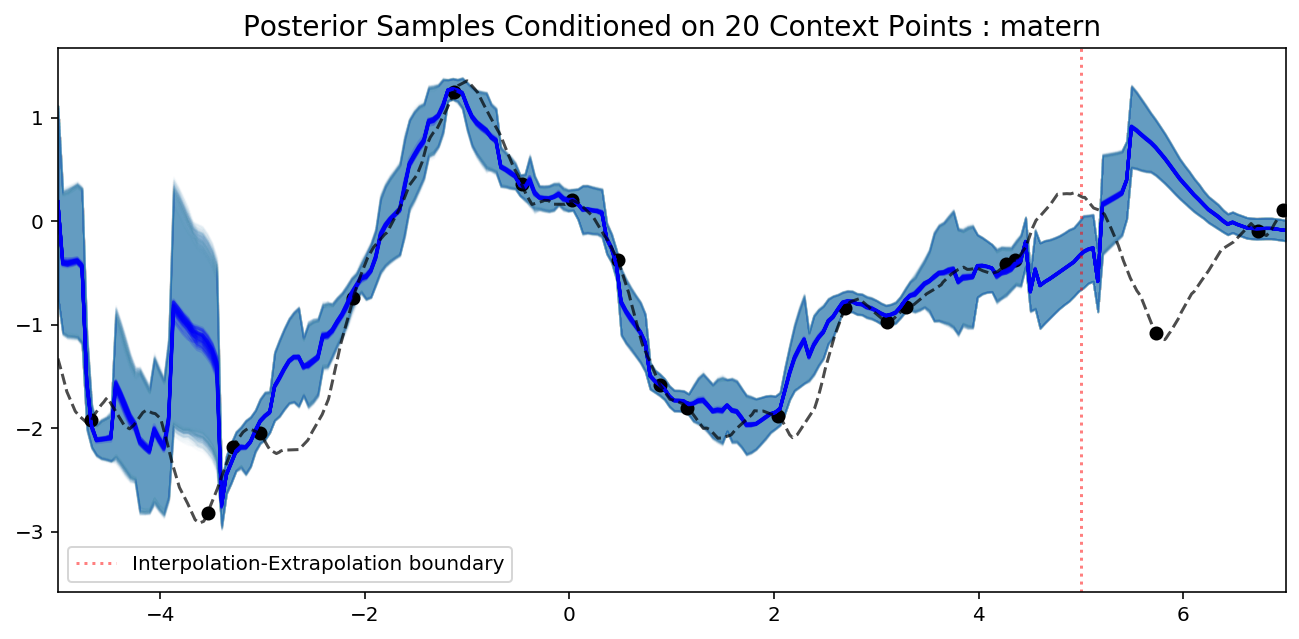

In [25]:
N_CNTXT = 20
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

std: 0.9187377655506136
std: 0.6319169712066651
std: 2.5428063964843743
std: 0.8465108835697172


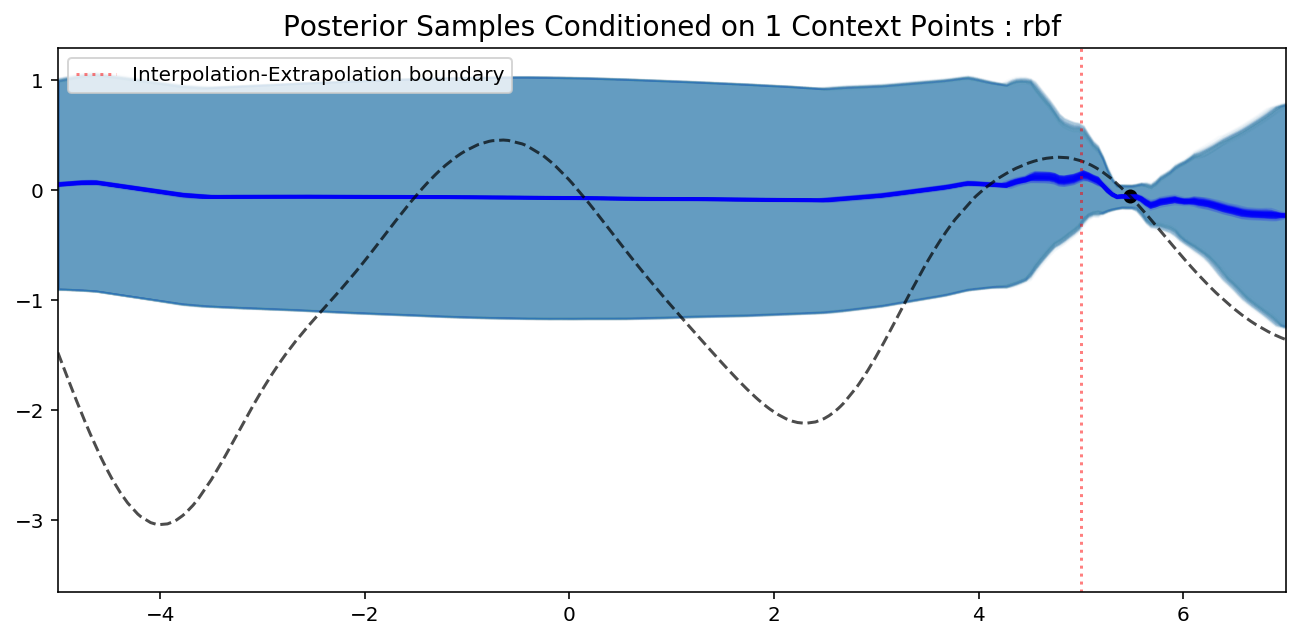

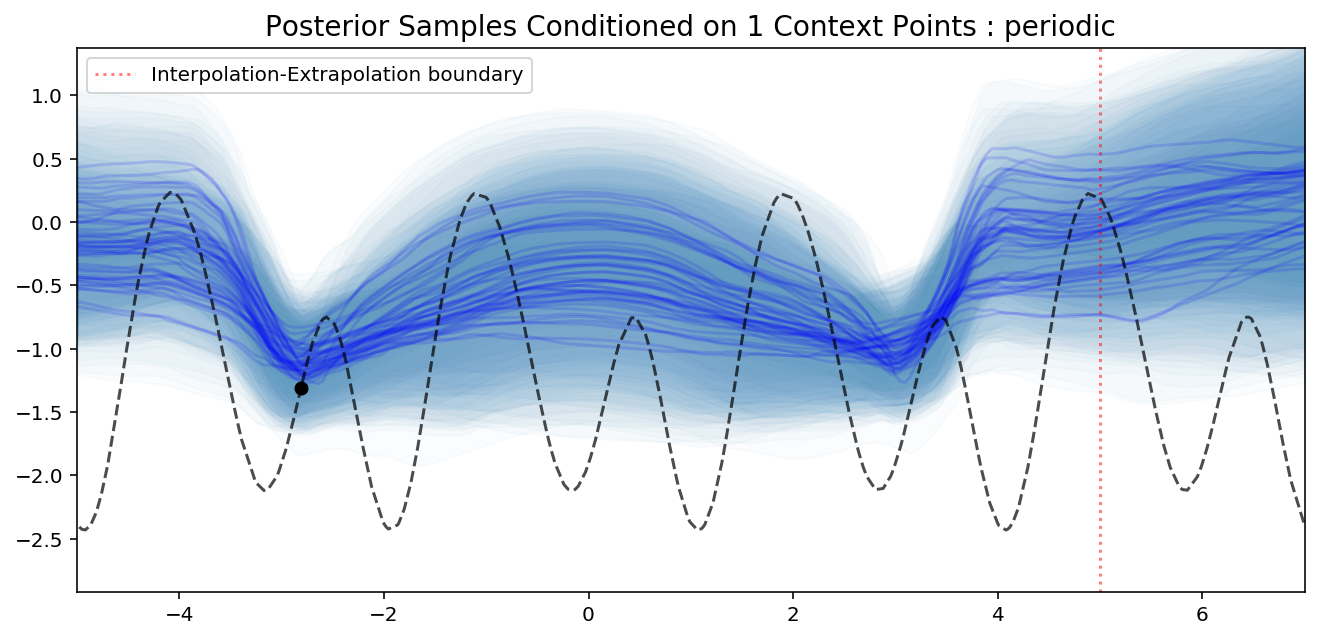

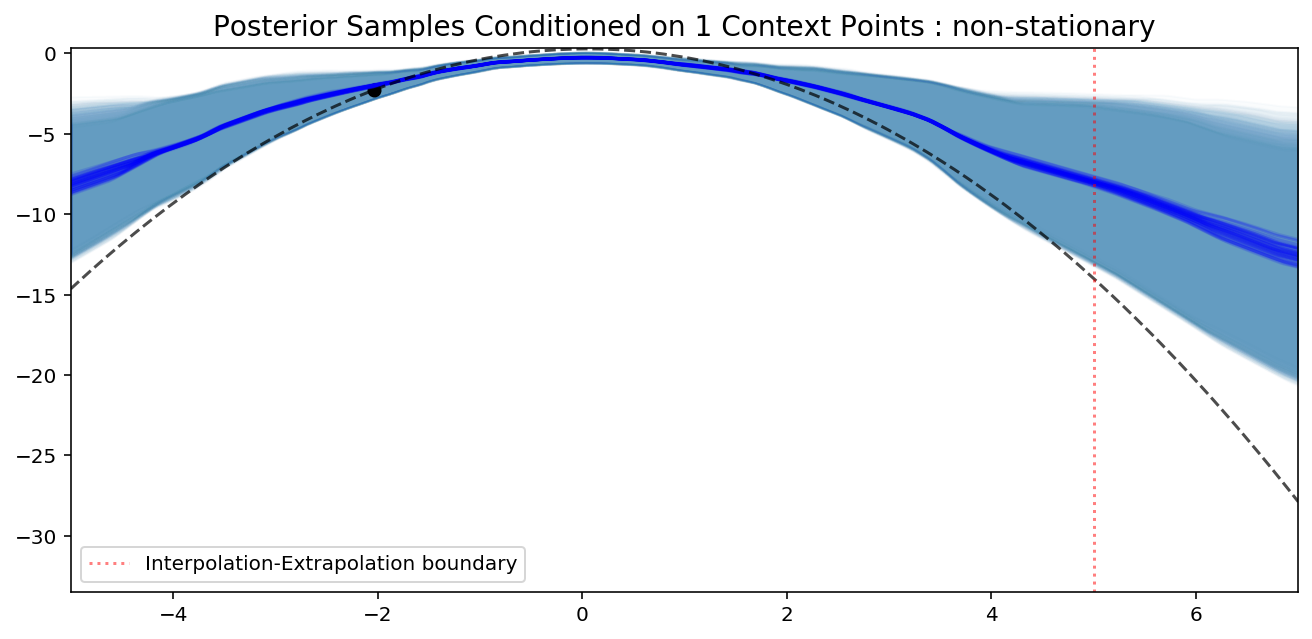

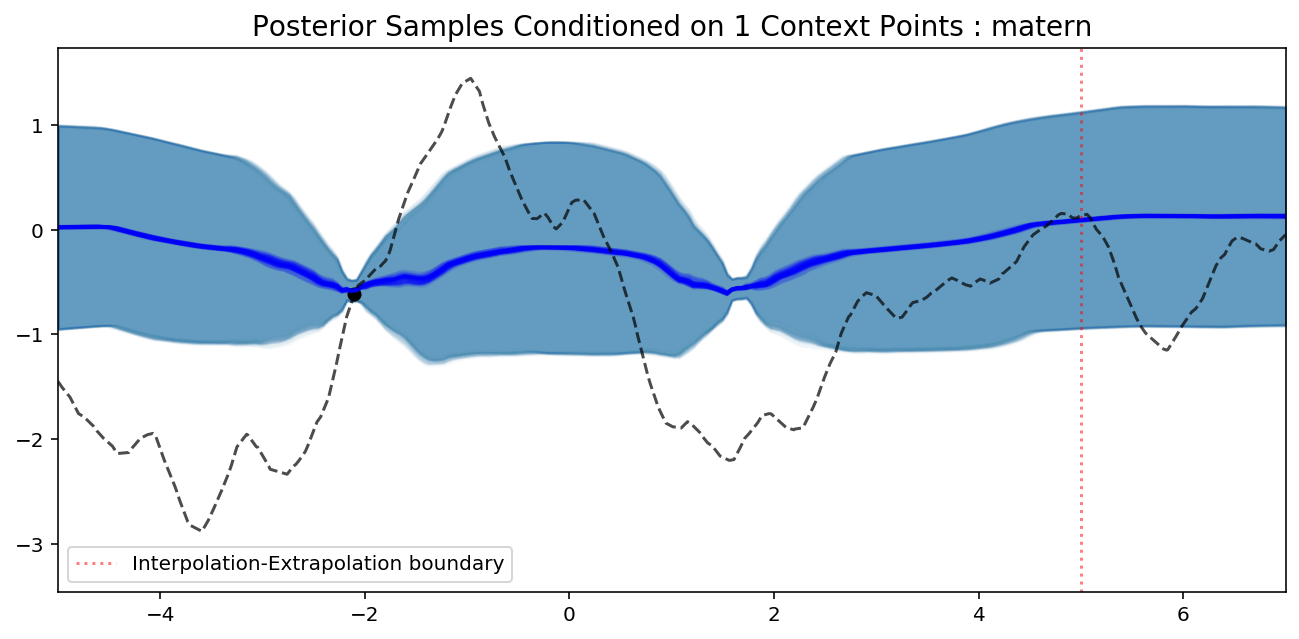

In [26]:
N_CNTXT = 1
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

We see that the predictions are much better than in [Tutorial 2 - Neural Process]

**Good**:
- the sampled function all go through or close to the context points
- the uncertainty decreases close to context points
- the samples all seem relatively different (not linear shifts like in [Tutorial 2 - Neural Process])

**Bad**:
- there seems to always be a strange "jump" in the middle of region between 2 far points. This is probably due to the softmax in cross attention, and disappears when using multihead attention. 
- cannot extrapolate and not even give high uncertainty when extrapolating

[Tutorial 2 - Neural Process]: Tutorial%202%20-%20Neural%20Process.ipynb